# "Engine knock detection AI part 5/5"
> A summary of the project is given. The training notebook is updated for fastai v2 and the resulting model is deployed as a Telegram bot.

- toc: true
- image: images/robot_crop.jpg

# Summary

Almost a year and a half ago I trained a model using the fastai library to identify knocking in a car engine.

The initial success had me really excited. This could be a really cool thing to continue working on. One could measure vibrations and sounds using contact microphones like pizeos to get better data and to train th model further. I found [otosense](https://www.analog.com/en/applications/technology/otosense.html), now aquired by Analog Devices, and [3d signals](https://3dsignals.com/). Two companies which seem to do something along those lines. 

The project was put on a back burner when the fall semester of 2019 kicked into full gear and kept there while studying from home during 2020.

The training notebook I've posted previously does not really run from start to finish anymore since the fastai library has been updated. I decided to train a new model with the same dataset but using fastai v2 this time. 

Now I've done more experimenting with different networks, but came to the conclusion that resnet34 as used originally seems like a good fit for now. Retraining the model with fastai v2 yields similar results as earlier.

To bring the project status to something resembling completion I've also deployed the trained model as a Telegram bot, [ismyengineknocking_bot](https://t.me/ismyengineknocking_bot). Send the bot a short video of an engine running and it will try to determine if it's running normally or knocking.


# Setup

Install the fastai library and initialize the notebook. This differs from how it was made in v1.

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 16.3MB/s 
     |████████████████████████████████| 194kB 35.6MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
Mounted at /content/gdrive


I left this piece in even if it's not really needed since the initialization in the last cell already mounts Drive. This just lets me copy and paste the paths from the earlier notebooks without change.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The obligatory importing of modules.

In [ ]:
from fastbook import *
from fastai.vision.all import *

Since typing this everytime gets old quickly.

In [ ]:
path = Path('/content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock/data')

# Load the training data

This differs slightly from earlier. The new syntax is a lot cleaner.

20% of the images are used for the validation set. These are images set aside from the data the model is trained on and are used to see how the model fares when presented with images not encountered previously.

In [ ]:
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    batch_tfms=Normalize(),
    item_tfms=Resize(224))

## Display images from dataset
This notebook does not delve into the depths of creating the dataset. Two notebooks have been published previously on the topic. In summary soundtracks from car maintenance videos on youtube were sliced up into two second clips. The images seen below are spectrograms of those clips showing the sound intensity at different frequencies as a function of time. 

Vertical bars or lines in the images represent rythmic content in the audio. As the audio recorded is of internal combustion engines the audio is composed mainly of a rhythmic texture. The model is expected to learn the difference of how the sound "looks" when the engine is _knocking_ versus when it's running normally. The knocking condition arises when ignition of the air/fuel mixture in one or more cylinders does not occur as it should. This can sound slightly different depending on the engine nd the exact condition and the resulting spectrogram can look very different.

The top right image shows a high intensity noise in the middle of the frequency range which is typical for the knocking engines in the dataset. The mid right shows wide spikes of a sound with distinct wavy horizontal lines. These represent the harmonic series of a human voice. In other words, I left in clips where the author of the video talks about the problems, or lack thereof. There are clips with narration in both the normal and knocking categories.

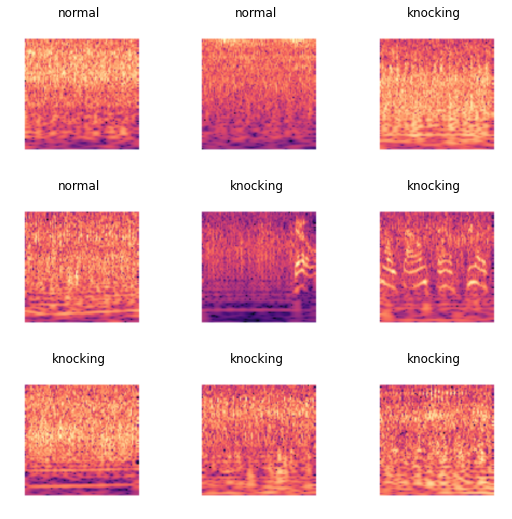

In [ ]:
dls = dataset.dataloaders(path)
dls.valid.show_batch(max_n=9, nrows=3)

# Train the model

The method from the previous training notebook is tested first. Syntax has changed slightly since fastai v1. The model is first trained for four epochs, the top layers unfrozen and then the learning rate finder is used to show the loss as a funtion of the step size, sometimes called alpha or learning rate like here.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.128035,0.887554,0.459770,01:23
1,0.930411,1.058884,0.482759,00:03
2,0.761746,1.076087,0.425287,00:02
3,0.652740,0.877649,0.344828,00:02


SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=7.585775847473997e-07)

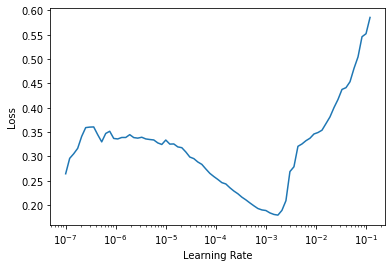

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

learn.fit_one_cycle(4)
learn.unfreeze()


In [ ]:
learn.lr_find()

The error rate and validation loss does not go down as far as during the previous training.

Validation loss is a metric which tells how well the model performs when it tries to categorize images in the validation set after training for a cycle.

The validation loss was about 10% smaller in the old notebook.

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(4e-6,4e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.320230,0.640691,0.229885,00:03
1,0.249299,0.581090,0.195402,00:03


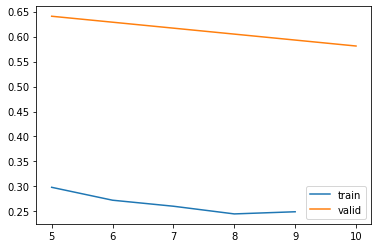

In [ ]:
learn.recorder.plot_loss()

The model seems to consistently guess that an engine is knocking while it actually is running well more often than the reverse. This was the case in the first notebook as well. It could be argued that this is a better scenario since this makes one err on the side of caution. The numbers are slightly worse than last time though.

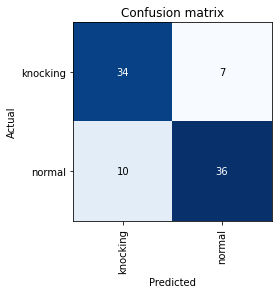

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Trying out resnet18 for a few epochs. The validation loss does not really impress at 0.75.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.166217,1.155197,0.540230,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.825857,1.285291,0.505747,00:02
1,0.620117,0.998950,0.448276,00:02
2,0.449343,0.805288,0.356322,00:02
3,0.350883,0.796160,0.252874,00:02
4,0.279821,0.772651,0.252874,00:02
5,0.230751,0.750805,0.252874,00:02


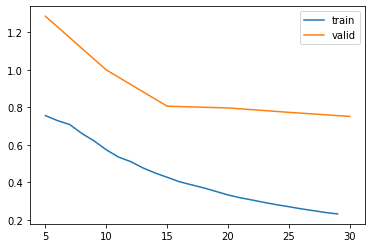

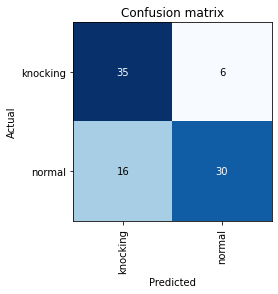

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Resnet50 is even worse with a validation loss which just keeps climbing with training.

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.172437,1.199191,0.528736,00:02
1,0.986341,0.814950,0.379310,00:02
2,0.749940,0.999910,0.356322,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.218681,0.925836,0.344828,00:03
1,0.221640,1.123302,0.310345,00:03
2,0.251672,1.212892,0.344828,00:03
3,0.221463,1.254364,0.310345,00:03
4,0.175679,1.195390,0.275862,00:03
5,0.145948,1.179999,0.275862,00:03


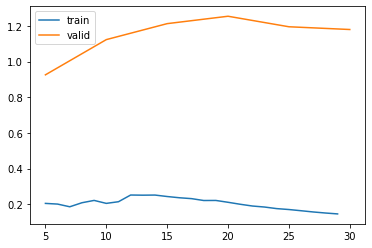

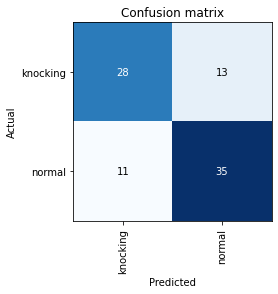

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Resnet34 gave the best results so far. In the following `fine_tune` gives similar results as running manually.

epoch,train_loss,valid_loss,error_rate,time
0,1.355901,1.024774,0.609195,00:03
1,1.209846,1.169116,0.505747,00:03
2,1.032370,1.075739,0.402299,00:02
3,0.853908,0.984360,0.333333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.358774,0.707381,0.241379,00:03
1,0.284909,0.626451,0.264368,00:03


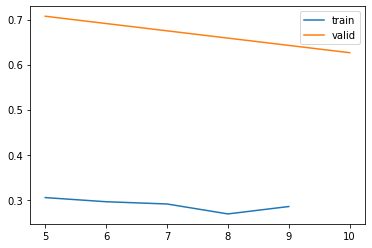

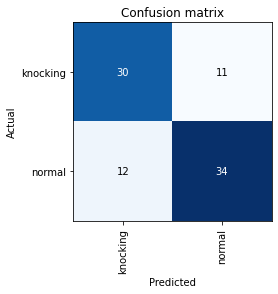

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, freeze_epochs=4)

learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The validation loss seems to be going down still. An increase of epochs after the freeze should be possible. The performance is till on par with the manual method. Metrics are not too far away from the first notebook.

epoch,train_loss,valid_loss,error_rate,time
0,1.374766,1.093510,0.643678,00:03
1,1.197061,1.271672,0.471264,00:02
2,0.976585,1.134578,0.379310,00:02
3,0.819463,0.856113,0.298851,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.320615,0.587391,0.229885,00:03
1,0.234541,0.593262,0.241379,00:03
2,0.201834,0.613296,0.252874,00:03
3,0.162961,0.466194,0.195402,00:03
4,0.130873,0.430470,0.149425,00:03
5,0.108552,0.419990,0.183908,00:03


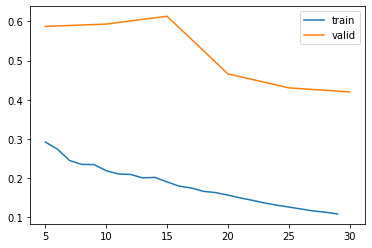

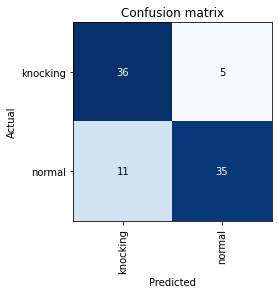

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(6, freeze_epochs=4)

learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Plot top losses
It seems like the model is guessing that spectrograms with vertical lines correspond to knocking, which would be correct. The bottom mid file has some narration which apparently threw the model off.

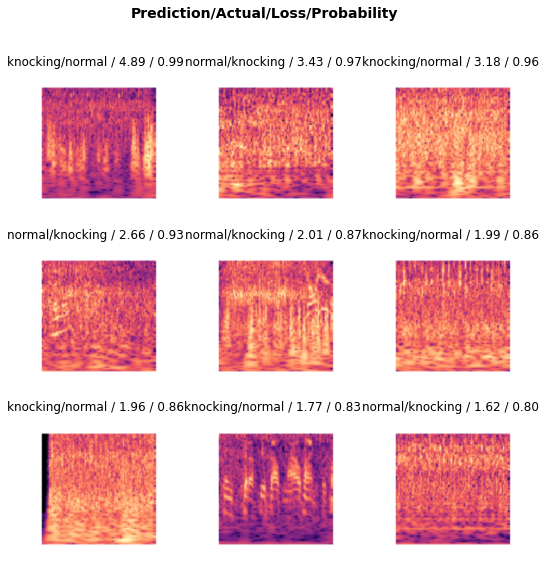

In [ ]:
interp.plot_top_losses(9, nrows=3)

Possible future exploration should involve trying to gather a bigger dataset. Also trying out the [fastaudio](https://github.com/fastaudio/fastaudio) package would be interesting.

# Preparations for deployment

## Checking package versions

Ideally the same versions of packages, libraries and tools should be used on the server which the model is deployed on. The versions used can be checked with the following.

In [ ]:
!python --version

Python 3.6.9


In [ ]:
import fastai
fastai.__version__

'2.2.5'

In [ ]:
torch.__version__

'1.7.0+cu101'

In [ ]:
import torchvision
torchvision.__version__

'0.8.1+cu101'

## Exporting the model

The model needs to be exported and copied over to a Drive folder so that it is retained when the Colab instance shuts down.

In [ ]:
learn.export("model_v2.pkl")

Copying the model to Google Drive for posteriority.

In [ ]:
!cp /content/model_v2.pkl /content/drive/MyDrive/Colab\ Notebooks/fast.ai/data/model_v2.pkl

# Testing the model

Load the model if starting from here.

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/fast.ai/data/model_v2.pkl /content/model_v2.pkl

In [ ]:
learn = load_learner("model_v2.pkl")

Load the outboard engine video, slice out the middle 2 seconds, create a spectrogram and let the model predict the state.

> youtube: https://youtu.be/Er0m4sy7ZyM

In [ ]:
project_path = '/content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock'
mov_filename = 'IMG_3414.MOV'

import moviepy.editor as mp
clip = mp.VideoFileClip(project_path + '/' + mov_filename)


In [ ]:
clip_start = (clip.duration/2)-1
clip_end = (clip.duration/2)+1

In [ ]:
clip = clip.subclip(clip_start,clip_end)

In [ ]:
sr = clip.audio.fps
y = clip.audio.to_soundarray()
y = y[...,0:1:1].flatten() # Take one channel, transform rows to columns, 1D

'knocking'

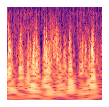

In [ ]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
from PIL import ImageMath
from fastai.data.external import *

D = librosa.stft(y)
D_harmonic, D_percussive = librosa.decompose.hpss(D)
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

side_px=256
dpi=150
plot = plt.figure(figsize=(side_px/dpi, side_px/dpi))

CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(librosa.istft(D_percussive), sr=sr)), ref=np.max)
p=librosa.display.specshow(CQT,x_axis=None,y_axis=None)
plt.axis('off')

plot.canvas.draw()

# https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
im_data = np.fromstring(plot.canvas.tostring_rgb(), dtype=np.uint8, sep='')
im_data = im_data.reshape(plot.canvas.get_width_height()[::-1] + (3,))

pred_class,pred_idx,outputs = learn.predict(im_data)
pred_class

In [ ]:
outputs[pred_idx]

tensor(1.0000)

The video is a bit of a stress test since the sound is from a single cylinder 4-stroke engine. A car engine has several cylinders which makes the sound "smoother" in comparison.

The following is a test of classifying a warmed up healthy Volvo V70 engine.

> youtube: https://youtu.be/qBAbQakgK60

'normal'

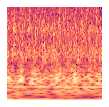

In [ ]:
import moviepy.editor as mp
import librosa
import matplotlib.pyplot as plt
import librosa.display
from PIL import ImageMath
from fastai.data.external import *

mov_filename = 'IMG_E5373.MOV'
project_path = '/content/drive/My Drive/Colab Notebooks/fast.ai/KnockKnock'

clip = mp.VideoFileClip(project_path + '/' + mov_filename)
clip_start = (clip.duration/2)-1
clip_end = (clip.duration/2)+1
clip = clip.subclip(clip_start,clip_end)
sr = clip.audio.fps
y = clip.audio.to_soundarray()
y = y[...,0:1:1].flatten()

D = librosa.stft(y)
D_harmonic, D_percussive = librosa.decompose.hpss(D)
rp = np.max(np.abs(D))

side_px=256
dpi=150
plot = plt.figure(figsize=(side_px/dpi, side_px/dpi))

CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(librosa.istft(D_percussive), sr=sr)), ref=np.max)
p=librosa.display.specshow(CQT,x_axis=None,y_axis=None)
plt.axis('off')

plot.canvas.draw()

im_data = np.fromstring(plot.canvas.tostring_rgb(), dtype=np.uint8, sep='')
im_data = im_data.reshape(plot.canvas.get_width_height()[::-1] + (3,))

pred_class,pred_idx,outputs = learn.predict(im_data)
pred_class

In [ ]:
outputs[pred_idx]

tensor(1.0000)

The above can only be read as that model is as confident as it can be about the engine running normally.

# Deployment as a telegram bot

Following the example from Kevin Degila's Medium post [_How to deploy Machine Learning models on Android and IOS with Telegram Bots_](https://medium.com/analytics-vidhya/how-to-deploy-machine-learning-models-on-android-and-ios-with-telegram-bots-a6fb16922741) it's possible to make the model relatively easily accessible for testing. The user can record a short video clip of their car running and send it to the bot for analysis. There's no need to build an app for mobile or even a web app where one would have to deal with clunky uploading UIs in mobile browsers. The user only needs the free chat app.

## Create the bot

Open the Telegram app and start a conversation with @BotFather. Give the `/newbot` command and answer the questions. An API key is given at the end of the conversation which needs to be used in the python file which defines the behaviour of the new bot.

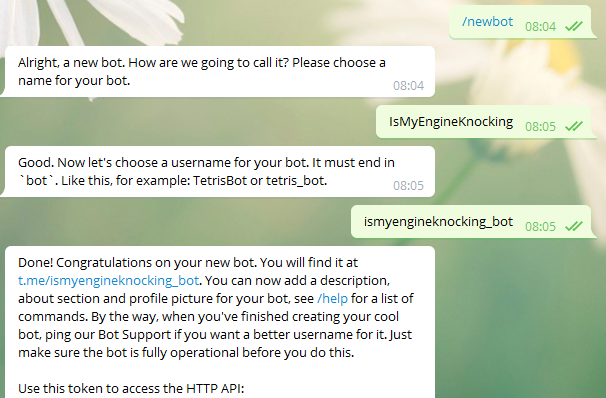

To start development on the local machine I'm using [Anaconda](https://www.anaconda.com/) to manage python environments, which means that I can have several different setups of python versions and associated modules installed for different projects.

With the tool installed the following can be entered in the Anaconda Prompt to create a new environment for this project with the same python version as this notebook was created on.

```
conda create --name knock python=3.6.9
```
and


```
conda activate knock
```


to change to the new environment. 

Fastai can be installed with


```
conda install -c fastai -c pytorch fastai=2.2.5
```



The module needed for connecting to the Telegram API is installed with


```
pip install python-telegram-bot
```



The moviepy module is used to load and slice the video file, librosa for creating spectrograms


```
pip install moviepy librosa
```



The entire functionality of the bot is defined in a file called `main.py`. The whole file, except the API key, is presented below.



```
import logging
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters
from fastai.vision.all import load_learner

import numpy as np
import moviepy.editor as mp
import librosa
import matplotlib.pyplot as plt
import librosa.display
from PIL import ImageMath
from fastai.data.external import *


# UNCOMMENT the following if running the bot LOCALLY ON WINDOWS
#import pathlib
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

def start(update, context):
	update.message.reply_text(
		"Bot by @niklasekman on Twitter \n\n"
		"Just send me a short (min 2s) video of your car engine running with the hood up and I'll try to tell you if it is running normally or possibly knocking.\nI will only look at 2 seconds in the middle of the video.\nYour video will not be saved. An example of what I'm expecting can be seen here https://youtu.be/qBAbQakgK60"
	)


def help_command(update, context):
	update.message.reply_text('I will tell you if your car engine is running normally or knocking. Send a short video.')

def load_model():
	global model
	model = load_learner('model_v2.pkl')
	print('Model loaded')

def create_spectrogram(filename):
	clip = mp.VideoFileClip(filename)
	clip_start = (clip.duration/2)-1
	clip_end = (clip.duration/2)+1
	clip = clip.subclip(clip_start,clip_end)
	sr = clip.audio.fps
	y = clip.audio.to_soundarray()
	y = y[...,0:1:1].flatten()

	D = librosa.stft(y)
	D_harmonic, D_percussive = librosa.decompose.hpss(D)
	rp = np.max(np.abs(D))

	side_px=256
	dpi=150
	plot = plt.figure(figsize=(side_px/dpi, side_px/dpi))

	CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(librosa.istft(D_percussive), sr=sr)), ref=np.max)
	p=librosa.display.specshow(CQT,x_axis=None,y_axis=None)
	plt.axis('off')

	plot.canvas.draw()

	im_data = np.fromstring(plot.canvas.tostring_rgb(), dtype=np.uint8, sep='')
	im_data = im_data.reshape(plot.canvas.get_width_height()[::-1] + (3,))
	return im_data

def infer_knocking(update, context):
	user = update.message.from_user
	video_file = update.message.video.get_file()
	video_file.download('user_video.mp4')
	label = model.predict(create_spectrogram('user_video.mp4'))[0]
	if label == "normal":
		update.message.reply_text("Your engine seems to be running well. If you are suspecting problems with your car, please contact a mechanic. I'm just a stupid bot and I'm giving my opinion after seeing literally 15 videos on youtube.")
	else:
		update.message.reply_text("Your engine could be knocking. If you are suspecting problems with your car, please contact a mechanic. I'm just a stupid bot and I'm giving my opinion after seeing literally 15 videos on youtube.")

def main():
	load_model()
	updater = Updater(token="************* API key **********", use_context=True)
	dp = updater.dispatcher
	dp.add_handler(CommandHandler("start", start))
	dp.add_handler(CommandHandler("help", help_command))

	dp.add_handler(MessageHandler(Filters.video, infer_knocking))

	updater.start_polling()
	updater.idle()

if __name__ == '__main__':
	main()
```



With the code from above in `main.py` in a suitable project directory run


```
python main.py
```

and start a chat with the bot. Mine is called [ismyengineknocking_bot](https://t.me/ismyengineknocking_bot) if you just want to try it out. Send a short video to it and get a guesstimation about the status of your engine.


## Deploy the bot to Heroku

The previous is what is needed to run the bot locally. For running continuously on a server one should use webhooks instead of polling. Referring to the line `updater.start_polling()` line near the end of the `main.py` file. Deploying on Heroku, as I've done, requires the project to be put under version contol with Git.

There are some more traps for young players which I've tried to summarize in the list under the next heading in bullet form. There are a lot of guides that can be found by googling `fastai telegram bot` but they mostly just take an image the user sends and feed it to the fastai `predict` function. Things can get a bit hairy if something more has to be done to process the data from the user.

[Heroku](https://www.heroku.com) is a hosting platform with a free tier for hobby and non-commercial projects.

The following steps need to be taken in order to get the bot running on the platform 

*   Create an account on [Heroku](https://www.heroku.com)
*   Go through the [Getting started guide](https://devcenter.heroku.com/articles/getting-started-with-python?singlepage=true) in the documentation
*   Install the [Git version control system](https://git-scm.com/)
*   Install the [Heroku command line interface ](https://devcenter.heroku.com/articles/heroku-cli)
*   Rewrite the python script to use [webhooks instead of polling](https://github.com/python-telegram-bot/python-telegram-bot/wiki/Webhooks#heroku)
*   Create a new app in the [Heroku dashboard](https://dashboard.heroku.com/)
*   Put the project under vesion control and push it to Heroku as per the instuctions on the **Deploy** tab in the dashboard
*   Turn the _dyno_ on under the **Resources** tab



As with any web development project the bot script will have dependencies, i.e. pieces of software written by other people that it relies on. Gathering all of them and making them work in the production environment can be a hassle. The following list contains both general advice and some specific things to note regarding this particular project.
*   Check the [Heroku Python Support](https://devcenter.heroku.com/articles/python-support) page to see which Python versions are available on different dynos. Test the script locally in a new anaconda environment first if it's necessary to up- or downgrade the version of Python.
*   Put the version of Python, e.g. `python-3.6.12` in a file called `runtime.txt`
*   See which modules the script is likely to need by issuing `pip freeze
` or `pip list --format=freeze` to see what's installed in the environment
*   Copy in the names of the most important modules along with the versions used into `requirements.txt` in the project directory. Mine looks like


```
python-telegram-bot==13.2
-f https://download.pytorch.org/whl/torch_stable.html
fastai==2.2.5
torch==1.7.1+cpu
torchvision==0.8.2+cpu
librosa==0.8.0
moviepy==1.0.3
SoundFile==0.10.3.post1
```
*   The installation of modules on the server may fail if all of the modules which are mentioned in the list from the earlier commands are copied into the requirements file. There might be incompatibilites that are difficult to predict that prevent installation of the exact versions of all modules. Specifying the ones that are absolutely necessary and letting pip resolve the rest of the modules is a better strategy 
*   Use the `cpu` versions of the `torch` and `torchvision` so that the _slug_ of your Heroku projects doesn't get too big (max is 500 MB)
*   The `librosa`, `moviepy` and `SoundFile` are specific to this project and are used to prepare videos.
*   There were some problems with installing the `librosa` module which were due to the fact that the Ubuntu based environment on Heroku does not have the `libsndfile1` and `libsndfile-dev` installed by default. They can be installed during the build by putting their names in a file called `Aptfile` and adding the community apt buildpack `heroku-community/apt` to the project under the **Settings** tab. See also the [heroku-buildpack-apt](https://elements.heroku.com/buildpacks/heroku/heroku-buildpack-apt) documentation.


